## **Import dependencies**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

#!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
tf.__version__

'1.14.0-rc1'

Download the  dataset.

In [0]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz


In [0]:
!unzip "/content/bird identification.zip"

Archive:  /content/bird identification.zip
   creating: bird identification/001.Black_footed_Albatross/
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0005_796090.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg  
  inflating: bird identification/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.j

In [0]:
base_dir = '/content/bird identification'

Splitting Data set

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.35,
    horizontal_flip='True',
    vertical_flip='True',
    samplewise_std_normalization=True,
    zca_whitening=True,
    featurewise_center=True,
    samplewise_center=True)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 996 images belonging to 26 classes.
Found 530 images belonging to 26 classes.


In [0]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


((16, 224, 224, 3), (16, 26))

Save the labels in a file which will be downloaded later.

In [0]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('/content/labbel.txt', 'w') as f:
  f.write(labels)

{'001.Black_footed_Albatross': 0, '002.Laysan_Albatross': 1, '003.Sooty_Albatross': 2, '019.Gray_Catbird': 3, '023.Brandt_Cormorant': 4, '024.Red_faced_Cormorant': 5, '025.Pelagic_Cormorant': 6, '044.Frigatebird': 7, '045.Northern_Fulmar': 8, '046.Gadwall': 9, '053.Western_Grebe': 10, '059.California_Gull': 11, '060.Glaucous_winged_Gull': 12, '062.Herring_Gull': 13, '063.Ivory_Gull': 14, '065.Slaty_backed_Gull': 15, '066.Western_Gull': 16, '086.Pacific_Loon': 17, '087.Mallard': 18, '090.Red_breasted_Merganser': 19, '092.Nighthawk': 20, '100.Brown_Pelican': 21, '101.White_Pelican': 22, '107.Common_Raven': 23, '108.White_necked_Raven': 24, '143.Caspian_Tern': 25}


In [0]:
!cat /content/labbel.txt

001.Black_footed_Albatross
002.Laysan_Albatross
003.Sooty_Albatross
019.Gray_Catbird
023.Brandt_Cormorant
024.Red_faced_Cormorant
025.Pelagic_Cormorant
044.Frigatebird
045.Northern_Fulmar
046.Gadwall
053.Western_Grebe
059.California_Gull
060.Glaucous_winged_Gull
062.Herring_Gull
063.Ivory_Gull
065.Slaty_backed_Gull
066.Western_Gull
086.Pacific_Loon
087.Mallard
090.Red_breasted_Merganser
092.Nighthawk
100.Brown_Pelican
101.White_Pelican
107.Common_Raven
108.White_necked_Raven
143.Caspian_Tern

## Create the base model from the pre-trained convnets

Create the base model from the **MobileNet V2** model developed at Google, and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [0]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(26, activation='softmax')
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)                858       
Total params: 2,627,514
Trainable params: 369,530
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [0]:
epochs = 25

history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:7

63/63 [==============================] - 19s 295ms/step - loss: 3.1852 - acc: 0.0813 - val_loss: 3.1877 - val_acc: 0.1094
Epoch 2/25
63/63 [==============================] - 9s 147ms/step - loss: 2.9503 - acc: 0.1275 - val_loss: 2.9161 - val_acc: 0.1491
Epoch 3/25
63/63 [==============================] - 9s 147ms/step - loss: 2.7371 - acc: 0.2108 - val_loss: 2.9503 - val_acc: 0.2000
Epoch 4/25
63/63 [==============================] - 9s 148ms/step - loss: 2.4329 - acc: 0.2861 - val_loss: 2.9282 - val_acc: 0.2585
Epoch 5/25
63/63 [==============================] - 9s 148ms/step - loss: 2.2086 - acc: 0.3584 - val_loss: 2.5244 - val_acc: 0.2962
Epoch 6/25
63/63 [==============================] - 9s 146ms/step - loss: 2.1104 - acc: 0.3725 - val_loss: 2.5064 - val_acc: 0.3094
Epoch 7/25
63/63 [==============================] - 9s 145ms/step - loss: 1.9563 - acc: 0.4177 - val_loss: 2.8646 - val_acc: 0.2755
Epoch 8/25
63/63 [==============================] - 10s 152ms/step - loss: 1.8065 - ac

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

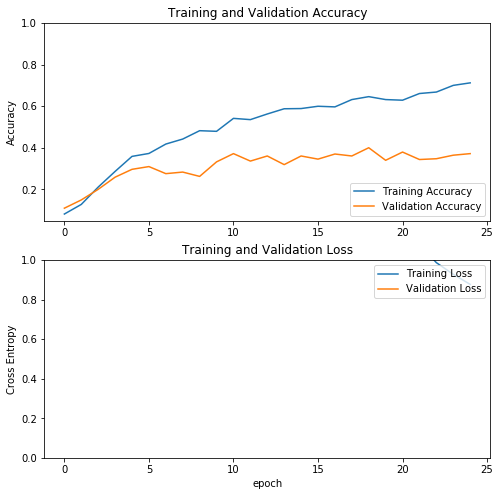

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [0]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)                858       
Total params: 2,627,514
Trainable params: 2,232,122
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


### Continue Train the model

In [0]:
history_fine = model.fit(train_generator, 
                         epochs=15,
                         validation_data=val_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:7

63/63 [==============================] - 24s 381ms/step - loss: 0.8418 - acc: 0.7209 - val_loss: 2.8275 - val_acc: 0.3811
Epoch 2/15
63/63 [==============================] - 10s 157ms/step - loss: 0.7409 - acc: 0.7550 - val_loss: 2.6600 - val_acc: 0.3755
Epoch 3/15
63/63 [==============================] - 10s 155ms/step - loss: 0.7093 - acc: 0.7651 - val_loss: 2.6493 - val_acc: 0.3811
Epoch 4/15
63/63 [==============================] - 10s 155ms/step - loss: 0.6388 - acc: 0.7892 - val_loss: 2.7994 - val_acc: 0.3736
Epoch 5/15
63/63 [==============================] - 10s 154ms/step - loss: 0.6227 - acc: 0.7892 - val_loss: 2.6038 - val_acc: 0.4170
Epoch 6/15
63/63 [==============================] - 10s 154ms/step - loss: 0.6641 - acc: 0.7600 - val_loss: 2.4434 - val_acc: 0.3868
Epoch 7/15
63/63 [==============================] - 10s 155ms/step - loss: 0.5804 - acc: 0.8243 - val_loss: 2.5421 - val_acc: 0.4151
Epoch 8/15
63/63 [==============================] - 10s 156ms/step - loss: 0.604

In [0]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
img_path = '/content/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
label = ['001.Black_footed_Albatross\n', '002.Laysan_Albatross\n', '003.Sooty_Albatross\n', '004.Groove_billed_Ani\n', '005.Crested_Auklet\n', '006.Least_Auklet\n', '007.Parakeet_Auklet\n', '008.Rhinoceros_Auklet\n', '009.Brewer_Blackbird\n', '010.Red_winged_Blackbird\n', '011.Rusty_Blackbird\n', '012.Yellow_headed_Blackbird\n', '013.Bobolink\n', '014.Indigo_Bunting\n', '015.Lazuli_Bunting\n', '016.Painted_Bunting\n', '017.Cardinal\n', '018.Spotted_Catbird\n', '019.Gray_Catbird\n', '020.Yellow_breasted_Chat\n', '021.Eastern_Towhee\n', '022.Chuck_will_Widow\n', '023.Brandt_Cormorant\n', '024.Red_faced_Cormorant\n', '025.Pelagic_Cormorant\n', '026.Bronzed_Cowbird\n', '027.Shiny_Cowbird\n', '028.Brown_Creeper\n', '029.American_Crow\n', '030.Fish_Crow\n', '031.Black_billed_Cuckoo\n', '032.Mangrove_Cuckoo\n', '033.Yellow_billed_Cuckoo\n', '034.Gray_crowned_Rosy_Finch\n', '035.Purple_Finch\n', '036.Northern_Flicker\n', '037.Acadian_Flycatcher\n', '038.Great_Crested_Flycatcher\n', '039.Least_Flycatcher\n', '040.Olive_sided_Flycatcher\n', '041.Scissor_tailed_Flycatcher\n', '042.Vermilion_Flycatcher\n', '043.Yellow_bellied_Flycatcher\n', '044.Frigatebird\n', '045.Northern_Fulmar\n', '046.Gadwall\n', '047.American_Goldfinch\n', '048.European_Goldfinch\n', '049.Boat_tailed_Grackle\n', '050.Eared_Grebe\n', '051.Horned_Grebe\n', '052.Pied_billed_Grebe\n', '053.Western_Grebe\n', '054.Blue_Grosbeak\n', '055.Evening_Grosbeak\n', '056.Pine_Grosbeak\n', '057.Rose_breasted_Grosbeak\n', '058.Pigeon_Guillemot\n', '059.California_Gull\n', '060.Glaucous_winged_Gull\n', '061.Heermann_Gull\n', '062.Herring_Gull\n', '063.Ivory_Gull\n', '064.Ring_billed_Gull\n', '065.Slaty_backed_Gull\n', '066.Western_Gull\n', '067.Anna_Hummingbird\n', '068.Ruby_throated_Hummingbird\n', '069.Rufous_Hummingbird\n', '070.Green_Violetear\n', '071.Long_tailed_Jaeger\n', '072.Pomarine_Jaeger\n', '073.Blue_Jay\n', '074.Florida_Jay\n', '075.Green_Jay\n', '076.Dark_eyed_Junco\n', '077.Tropical_Kingbird\n', '078.Gray_Kingbird\n', '079.Belted_Kingfisher\n', '080.Green_Kingfisher\n', '081.Pied_Kingfisher\n', '082.Ringed_Kingfisher\n', '083.White_breasted_Kingfisher\n', '084.Red_legged_Kittiwake\n', '085.Horned_Lark\n', '086.Pacific_Loon\n', '087.Mallard\n', '088.Western_Meadowlark\n', '089.Hooded_Merganser\n', '090.Red_breasted_Merganser\n', '091.Mockingbird\n', '092.Nighthawk\n', '093.Clark_Nutcracker\n', '094.White_breasted_Nuthatch\n', '095.Baltimore_Oriole\n', '096.Hooded_Oriole\n', '097.Orchard_Oriole\n', '098.Scott_Oriole\n', '099.Ovenbird\n', '100.Brown_Pelican\n', '101.White_Pelican\n', '102.Western_Wood_Pewee\n', '103.Sayornis\n', '104.American_Pipit\n', '105.Whip_poor_Will\n', '106.Horned_Puffin\n', '107.Common_Raven\n', '108.White_necked_Raven\n', '109.American_Redstart\n', '110.Geococcyx\n', '111.Loggerhead_Shrike\n', '112.Great_Grey_Shrike\n', '113.Baird_Sparrow\n', '114.Black_throated_Sparrow\n', '115.Brewer_Sparrow\n', '116.Chipping_Sparrow\n', '117.Clay_colored_Sparrow\n', '118.House_Sparrow\n', '119.Field_Sparrow\n', '120.Fox_Sparrow\n', '121.Grasshopper_Sparrow\n', '122.Harris_Sparrow\n', '123.Henslow_Sparrow\n', '124.Le_Conte_Sparrow\n', '125.Lincoln_Sparrow\n', '126.Nelson_Sharp_tailed_Sparrow\n', '127.Savannah_Sparrow\n', '128.Seaside_Sparrow\n', '129.Song_Sparrow\n', '130.Tree_Sparrow\n', '131.Vesper_Sparrow\n', '132.White_crowned_Sparrow\n', '133.White_throated_Sparrow\n', '134.Cape_Glossy_Starling\n', '135.Bank_Swallow\n', '136.Barn_Swallow\n', '137.Cliff_Swallow\n', '138.Tree_Swallow\n', '139.Scarlet_Tanager\n', '140.Summer_Tanager\n', '141.Artic_Tern\n', '142.Black_Tern\n', '143.Caspian_Tern\n', '144.Common_Tern\n', '145.Elegant_Tern\n', '146.Forsters_Tern\n', '147.Least_Tern\n', '148.Green_tailed_Towhee\n', '149.Brown_Thrasher\n', '150.Sage_Thrasher\n', '151.Black_capped_Vireo\n', '152.Blue_headed_Vireo\n', '153.Philadelphia_Vireo\n', '154.Red_eyed_Vireo\n', '155.Warbling_Vireo\n', '156.White_eyed_Vireo\n', '157.Yellow_throated_Vireo\n', '158.Bay_breasted_Warbler\n', '159.Black_and_white_Warbler\n', '160.Black_throated_Blue_Warbler\n', '161.Blue_winged_Warbler\n', '162.Canada_Warbler\n', '163.Cape_May_Warbler\n', '164.Cerulean_Warbler\n', '165.Chestnut_sided_Warbler\n', '166.Golden_winged_Warbler\n', '167.Hooded_Warbler\n', '168.Kentucky_Warbler\n', '169.Magnolia_Warbler\n', '170.Mourning_Warbler\n', '171.Myrtle_Warbler\n', '172.Nashville_Warbler\n', '173.Orange_crowned_Warbler\n', '174.Palm_Warbler\n', '175.Pine_Warbler\n', '176.Prairie_Warbler\n', '177.Prothonotary_Warbler\n', '178.Swainson_Warbler\n', '179.Tennessee_Warbler\n', '180 180.Wilson_Warbler\n', '181.Worm_eating_Warbler\n', '182.Yellow_Warbler\n', '183.Northern_Waterthrush\n', '184.Louisiana_Waterthrush\n', '185.Bohemian_Waxwing\n', '186.Cedar_Waxwing\n', '187.American_Three_toed_Woodpecker\n', '188.Pileated_Woodpecker\n', '189 189.Red_bellied_Woodpecker\n', '190.Red_cockaded_Woodpecker\n', '191.Red_headed_Woodpecker\n', '192.Downy_Woodpecker\n', '193.Bewick_Wren\n', '194.Cactus_Wren\n', '195.Carolina_Wren\n', '196.House_Wren\n', '197.Marsh_Wren\n', '198.Rock_Wren\n', '199.Winter_Wren\n', '200.Common_Yellowthroat\n']
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
#print(x.shape)

features = model.predict(x)
ind = features.argmax()
#print('Predicted Array:',features)
print('Predicted Label:',label[ind])

FileNotFoundError: ignored

In [0]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

## Convert to TFLite

In [0]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'my_model.h5')
tfmodel = converter.convert()
open ("93acc.tflite" , "wb") .write(tfmodel)

In [0]:

import tensorflow as tf
saved_model_dir = '/content/my_model.h5'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("bird_model.tflite", "wb").write(tflite_quantized_model)

In [0]:
print(model)

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [0]:
saved_model_dir = '/content/save/fine_tuning/'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Download the converted model and labels

In [0]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the orginial dataset that the pre-trained model was trained on.
